# NYC taxi trips on Thanksgiving 2018 analysis

In this project we will be analyzing a dataset containing information regarding NY taxi trips on Thanksgiving 2018.

The scope of the project includes several steps:
1. **Explore and clean the data:** As in any other project, there is a fundamental first phase that needs to be implemented in order to validate the completeness and the correctness of data. First, the nature of the data will be explored, to know the nº of samples, nº of variables and how data is distributed. Besides, data will be cleaned to ease more advanced analytics that will follow in the next stages.
<br><br>
2. **Data summary and relevant trends:** The NY city council is very interested on understanding taxi trips on thanksgiving. We will attempt to discover relevant insights that may be very impactful for public politics. Therefore, we will look for trends on data and present them on such a way that workers at the NY city council can easily interpret them. This stage will involve exploring relations among variables that may lead to insightful findings. On top of that, visualizations will be very useful to understand relations and to bring to light hidden patterns on data.
<br><br>
3. **Model building:** Finally, the NY city council is interested on the typical tip clients give to taxi drivers and what factors influence the tip the most. In order to do so, we will be focusing our analysis on the tips building several machine learning models that may help us and the city council to understand how tips behave.

## Libraries and configuration

First we begin importing useful libraries for data management, visualization and building models.

In [1]:
import pandas as pd
import numpy as np
import shapefile as shp
import geopandas

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

Configure colors and visualitation style.

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})
color_palette = ['#ffa600', '#ff766e', "#e770af", "#937ec3", "#517ea6"]
three_color = ["#ff766e", "#517ea6", "#ffa600", "#937ec3", "#e770af"]
color = "#ff766e"


sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': '#fafcfb',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

## 1. Data exploration and cleaning

### Data importation

First, we proceed to import data in *.csv* format and save it into a pandas dataframe.

In [3]:
df = pd.read_csv('ny_thanksgiving_2018.csv')

### Basic data exploration

Now we proceed to perform basic data exploration. Let's first visualize how the first samples look like.

It seems like each row represents a single taxi trip. It contains several variables each of them describing different category of the trip.

In [4]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
0,2,2018-11-22 18:28:51,2018-11-22 18:33:10,1,0.0,1,N,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193,193
1,2,2018-11-22 02:00:35,2018-11-22 02:00:39,1,0.0,1,N,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264,264
2,2,2018-11-22 13:54:37,2018-11-22 13:54:42,1,0.0,1,N,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264,152
3,2,2018-11-22 01:38:35,2018-11-22 01:40:48,1,0.0,1,N,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193,193
4,1,2018-11-22 19:07:20,2018-11-22 19:07:20,0,0.0,5,N,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158,264


But...how many taxi trips the dataset contains? And how many variables?

In [5]:
print(df.shape)

(174347, 17)


In [6]:
n_rows = df.shape[0]
n_columns = df.shape[1]
print("The dataset contains information about " + str(n_rows) + " taxi trips.")
print("The information of each taxi trip is stored in " + str(n_columns) + " different varaibles.")

The dataset contains information about 174347 taxi trips.
The information of each taxi trip is stored in 17 different varaibles.


Before proceeding with further analysis it is essential to know the kind of variables the dataset contains. Let's begin by retrieving all the names of the variables and its types.

We have 14 numerical variables and 3 object variables. ***pickup_datetime*** and ***dropoff_datetime*** are of type string but maybe it is worth to convert them to datetime so it is easier to operate when needed. We will do it later on.

In [7]:
df.dtypes

vendor_id                int64
pickup_datetime         object
dropoff_datetime        object
passenger_count          int64
trip_distance          float64
rate_code                int64
store_and_fwd_flag      object
payment_type             int64
fare_amount            float64
extra                  float64
mta_tax                float64
tip_amount             float64
tolls_amount           float64
imp_surcharge          float64
total_amount           float64
pickup_location_id       int64
dropoff_location_id      int64
dtype: object

### Feature creation and transformation

In this subsection we will perform some feature engineering by creating new features from the ones we already have.

Convert time variables into date-time types.

In [8]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

Now from these variables we can obtain ***trip_duration*** in seconds.

In [9]:
df["trip_duration"] = df["dropoff_datetime"] - df["pickup_datetime"]
df["trip_duration"] = df["trip_duration"].map(lambda x: x.total_seconds())

Check it has been created correctly.

In [10]:
df[["pickup_datetime", "dropoff_datetime", "trip_duration"]][:2]

,pickup_datetime,dropoff_datetime,trip_duration
0,2018-11-22 18:28:51,2018-11-22 18:33:10,259.0
1,2018-11-22 02:00:35,2018-11-22 02:00:39,4.0


Now, with the ***trip_distance*** and the ***trip_duration*** we can obtain the average ***trip_speed***. Let's calculate it in KM/h as we are more familiar with this unit (convert milles to km, seconds to hours and divide).

Prior to calculate the ***trip_speed*** lets drop rows that have either 0 duration or 0 distance to avoid inconsistent results such as 0 speed or infinite speed.

In [11]:
df = df[(df["trip_distance"] != 0)]
df = df[(df["trip_duration"] != 0)]

Now we can calculate ***trip_speed***

In [12]:
df["trip_speed"] = df["trip_distance"] / df["trip_duration"]
df["trip_speed"] = df["trip_speed"] * (1.60934 * 3600) # Convert milles to km (1 mille = 1.609 Km) and seconds to hours (1 h =3600 s)

Let's check results make sense

In [13]:
df[["trip_speed", "trip_distance", "trip_duration"]].tail(3)

,trip_speed,trip_distance,trip_duration
174344,24.976665,11.42,2649.0
174345,47.576407,8.45,1029.0
174346,20.210316,0.30,86.0


We can also create other new features from the time variables.

We can create features that to make the analysis more human understandable. 

With this purpose we will create a feature displaying the hour of the trip and other specifying if it was during morning, afternoon, evening, night or late night.

In [14]:
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["dropoff_hour"] = df["dropoff_datetime"].dt.hour

Create a function to calculate categorical times of day.

In [15]:
def day_time(hour):
    if hour in range(6, 12):
        return "Morning"
    elif hour in range(12, 16):
        return "Afternoon"
    elif hour in range(16, 21):
        return "Evening"
    elif hour in range(21, 24):
        return "Night"
    else:
        return "Late Night"

Create two new features:
* ***pickup_day_time***: Time of the day for the pick-up
* ***dropoff_day_time***: Time of the day for the drop-off

In [16]:
df["pickup_day_time"] = df["pickup_hour"].map(day_time)
df["dropoff_day_time"] = df["dropoff_hour"].map(day_time)

Let's check that it was done correctly

In [17]:
df[["pickup_hour", "pickup_day_time"]][-3:]

,pickup_hour,pickup_day_time
174344,13,Afternoon
174345,10,Morning
174346,2,Late Night


### Dealing with Nulls and outliers

#### Nulls

One of the first things to check in this type of analysis is data completeness. We will be checking how many Nulls we find per variable.

We have been very lucky, there is not a single Null for any of the features!!!

In [18]:
df.isna().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
rate_code              0
store_and_fwd_flag     0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
total_amount           0
pickup_location_id     0
dropoff_location_id    0
trip_duration          0
trip_speed             0
pickup_hour            0
dropoff_hour           0
pickup_day_time        0
dropoff_day_time       0
dtype: int64

#### Outliers

Now we can visualise basic statistics of the dataset variables.

There are some variables that in reality are categorical as indicated in https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf, such as vendor_id, rate_code, pickup_location_id or dropoff_location_id.

Regarding the numerical variables it is worth highlighting the ones that have to do with costs of the trip: ***fare_amount***, ***extra***, ***mta_tax***, ***tip_amount***, ***tolls_amount***, ***imp_surcharge*** and ***total_amount***. All of these variables include minimum values that are negative. If these negative values do not make sense we will drop these samples

In [19]:
df.describe()

,vendor_id,passenger_count,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,trip_duration,trip_speed,pickup_hour,dropoff_hour
count,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000,172969.000000
mean,1.678272,1.660702,3.041247,1.047425,1.423533,13.171287,0.179828,0.497034,1.448600,0.295242,0.299400,15.898855,162.822789,159.002949,948.067197,24.327385,13.458839,13.506669
std,0.577997,1.261571,3.915027,0.402343,0.513614,450.799021,0.269413,0.044204,2.391418,1.448527,0.018856,450.858445,68.368668,72.468971,4704.482780,110.488284,6.353704,6.400172
min,1.000000,0.000000,0.010000,1.000000,1.000000,-200.000000,-4.500000,-0.500000,-11.000000,-10.000000,-0.300000,-200.300000,1.000000,1.000000,1.000000,0.004023,0.000000,0.000000
25%,1.000000,1.000000,0.970000,1.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000,7.550000,113.000000,100.000000,312.000000,15.866356,10.000000,10.000000
50%,2.000000,1.000000,1.700000,1.000000,1.000000,8.500000,0.000000,0.500000,1.000000,0.000000,0.300000,10.380000,161.000000,162.000000,525.000000,20.318484,14.000000,14.000000
75%,2.000000,2.000000,3.230000,1.000000,2.000000,13.500000,0.500000,0.500000,2.000000,0.000000,0.300000,16.000000,233.000000,233.000000,885.000000,26.637352,19.000000,19.000000
max,4.000000,8.000000,101.300000,99.000000,4.000000,187436.460000,18.000000,0.500000,150.000000,44.000000,0.300000,187437.760000,265.000000,265.000000,86398.000000,22015.771200,23.000000,23.000000


In [20]:
df = df[df['trip_speed'].notna()]

In the plots below we visualize the distributions for all numerical variables.

The distributions reveal some outliers. As observed, there are some negative values for ***fare_amount***, ***tolls_amount***, ***tip_amount*** and ***total_amount***. Since we have a dataset with a large number of samples we can afford to drop outliera with the purpose of not spoiling the later analysis and modelling.

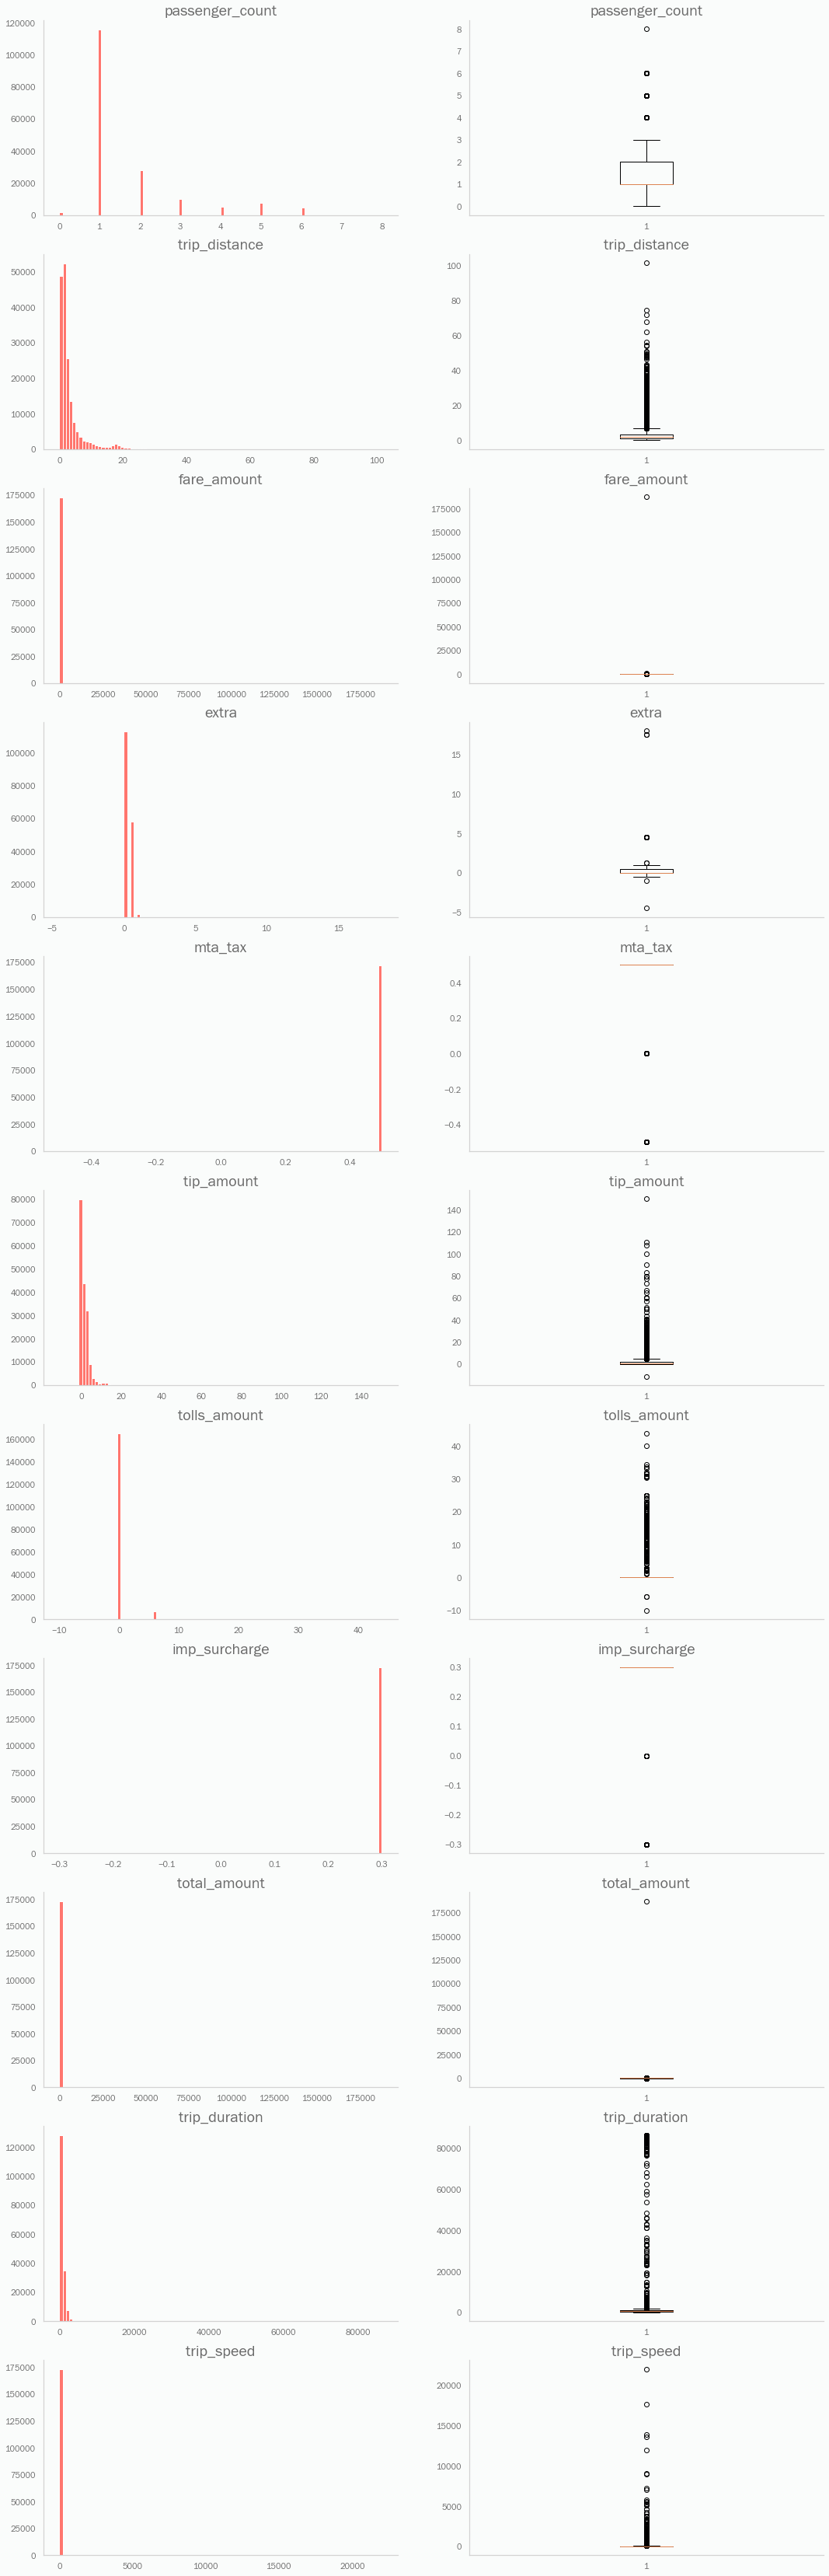

In [21]:
numerical_columns = ["passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "imp_surcharge", "total_amount", "trip_duration", "trip_speed"]

fig, axs = plt.subplots(len(numerical_columns), 2, figsize=(18,60))
for i, column in enumerate(numerical_columns):
    axs[i, 0].hist(df[column], bins=100, color = color)
    axs[i, 0].set_title(column)
    
    axs[i, 1].boxplot(df[column])
    axs[i, 1].set_title(column)

Let's drop the samples with ***fare_amount*** over 100000.
Let's drop the samples with negative fare amount, altough we don't know the reason (it could mean a refund) it is not worth taking the risk and just drop these samples.

In [22]:
df = df[df["fare_amount"] < 100000]
df = df[df["fare_amount"] > 0]

Let's drop trips with a number of passengers equal to 0 as it is pretty strange, and it might be an anotation failure. Since we have a lot of samples it is ok to remove them. We will also drop the trip with 8 passengers to avoid great outliers.

In [23]:
df = df[df["passenger_count"] != 0]
df = df[df["passenger_count"] != 8]

Moreover, it doesn't make sense trips with an average speed over 152 Km/h given that are trips in a city. Since they are not much we can just drop them to support consistency between distance and duration.

In [24]:
df = df[df["trip_speed"] < 152]

Besides, there are trips that have a ridiculous duration over 8 hours (8hours == 28800s) and more. We will drop them since probably the pick-up and drop-off time were incorrect.

In [25]:
df = df[df["trip_duration"] < 28800]

There are also outliers for ***mta_tax*** and the ***imp_surcharge*** that should always have the same values, 0.5 and 0.3 respectively. However, in this case we will not drop the samples as they just have 0 for these two variables and the values for other columns seem normal.

Now the distributions make much more sense

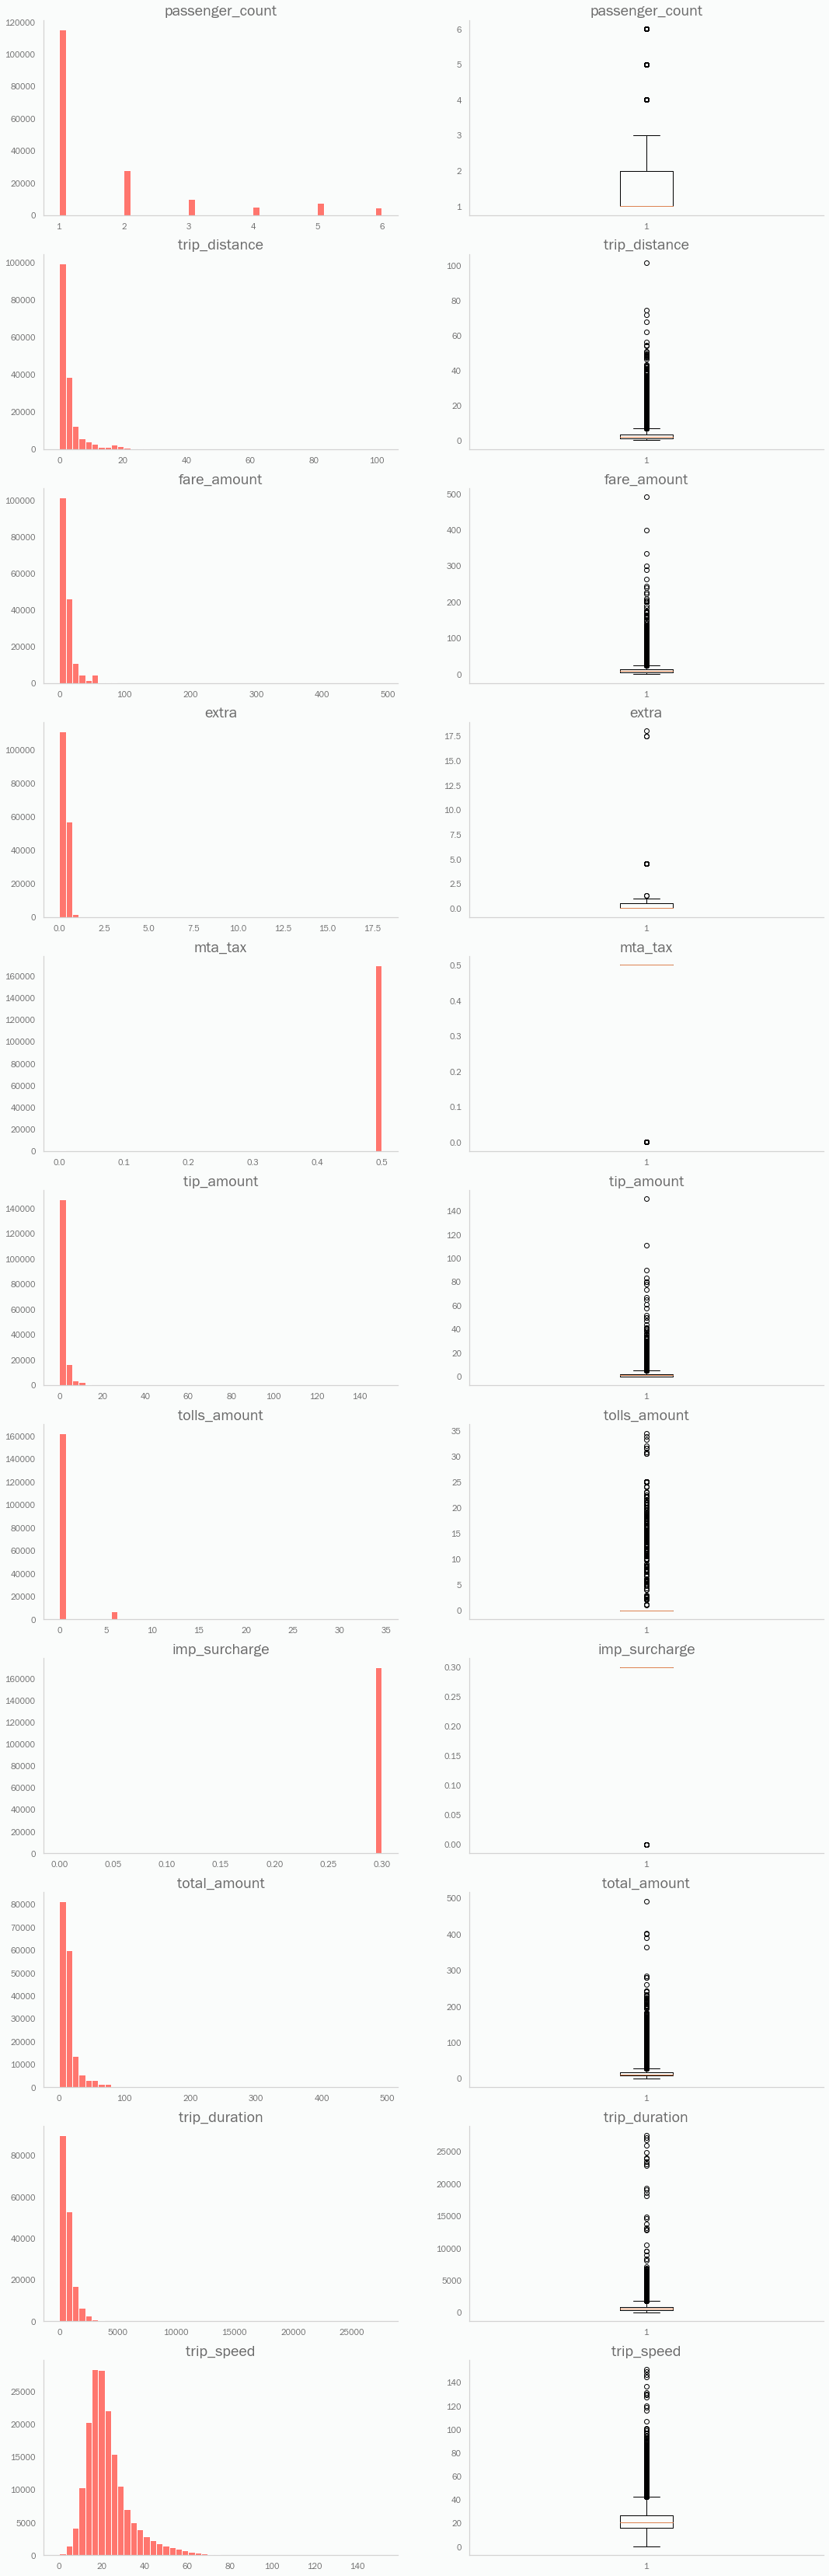

In [26]:
numerical_columns = ["passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "imp_surcharge", "total_amount", "trip_duration", "trip_speed"]

fig, axs = plt.subplots(len(numerical_columns), 2, figsize=(18,60))
for i, column in enumerate(numerical_columns):
    axs[i, 0].hist(df[column], bins=50, color=color)
    axs[i, 0].set_title(column)
    
    axs[i, 1].boxplot(df[column])
    axs[i, 1].set_title(column)

Let's take a look if there is wrong data in ***rate_code***.

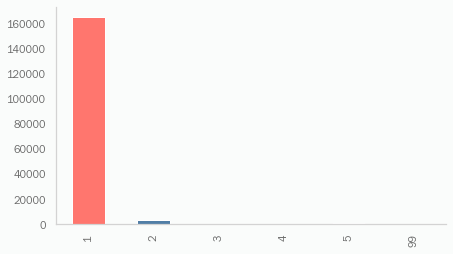

In [27]:
df["rate_code"].value_counts().sort_index().plot.bar(x='rate_code', y='Number of Occurrences', colors=three_color, figsize=(7,4))
plt.show()

We have few samples with ***rate_code = 99*** but this value was not indicated in the dataset information so we will drop them.

In [28]:
df = df[df["rate_code"] != 99]

The distribution of ***store_and_fwd_flag*** is quite unbalanced, but we will leave it like that.

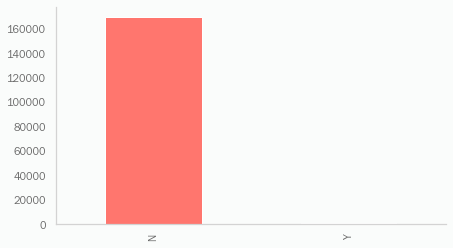

In [29]:
df["store_and_fwd_flag"].value_counts().sort_index().plot.bar(x='store_and_fwd_flag', y='Number of Occurrences', color=three_color, figsize=(7,4))

We have two dominating ***vendor_id***, vendor 1 and vendor 2.

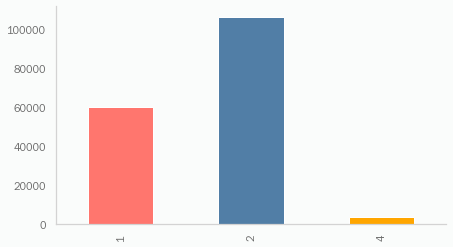

In [30]:
df["vendor_id"].value_counts().sort_index().plot.bar(x='vendor_id', y='Number of Occurrences', color=three_color, figsize=(7,4))

We have credit card (1) and cash (2) payments dominating for ***payment_type***

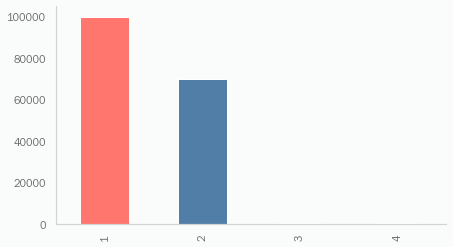

In [31]:
df["payment_type"].value_counts().sort_index().plot.bar(x='payment_type', y='Number of Occurrences', color=three_color, figsize=(7,4))

Let's reset the index of the dataframe now that we have finished cleaning data.

In [32]:
df = df.reset_index(drop=True)

The final statistics of the variables look like that.

In [33]:
df.describe()

,vendor_id,passenger_count,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,trip_duration,trip_speed,pickup_hour,dropoff_hour
count,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000,170194.000000
mean,1.685018,1.678731,3.038704,1.045184,1.420397,12.085874,0.180489,0.498228,1.448652,0.294055,0.299986,14.814869,162.773094,158.957866,686.944593,22.750008,13.458113,13.506645
std,0.577510,1.255542,3.910349,0.317241,0.508955,11.381610,0.269357,0.029709,2.354134,1.437351,0.002057,13.613608,68.369443,72.458772,592.533093,10.779970,6.354973,6.400412
min,1.000000,1.000000,0.010000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,1.000000,1.000000,2.000000,0.076635,0.000000,0.000000
25%,1.000000,1.000000,0.970000,1.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000,7.560000,113.000000,100.000000,313.000000,15.910848,10.000000,10.000000
50%,2.000000,1.000000,1.700000,1.000000,1.000000,8.500000,0.000000,0.500000,1.000000,0.000000,0.300000,10.380000,161.000000,162.000000,525.000000,20.346353,14.000000,14.000000
75%,2.000000,2.000000,3.230000,1.000000,2.000000,13.500000,0.500000,0.500000,2.000000,0.000000,0.300000,16.000000,233.000000,233.000000,881.000000,26.656110,19.000000,19.000000
max,4.000000,6.000000,101.300000,5.000000,4.000000,491.000000,18.000000,0.500000,150.000000,34.520000,0.300000,491.800000,265.000000,265.000000,27551.000000,151.391180,23.000000,23.000000


## 2. Data summary

In this section the goal is to find some trends and hidden patterns on data involving different visualitations and combinations of variables.

### Hour and time of day
Let's look first how taxi trips are distributed with respect to time. Since most of trips are quite short with a mean duration of 686 seconds (~11 min) we can take either pick-up times or drop-off, it won't affect much the analysis.

We can see that the period od less taxi trips activity is between 1 and 8. From 8 onwards there is a quick increase on trips activity until 12, where more or less the peak of activity is found. There is a constant high activity of taxi activity until 16 when the activity is slightly reduced. During 20 and 21 there is again high activity to later decrease from 22.

Similarly the times of day with greater activity are afternoon and evening. On the other side, the day times with least activity are Night and Late Night.

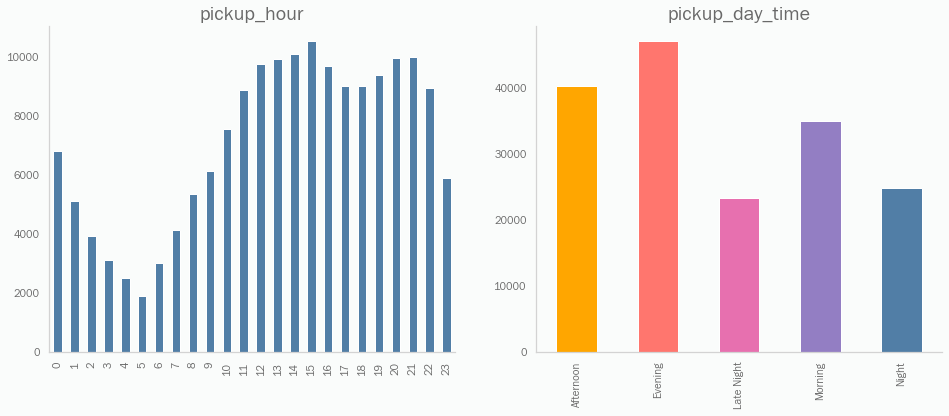

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = df["pickup_hour"].value_counts().sort_index().plot.bar(x='pickup_hour', y='Number of Occurrences', ax =axes[0], color=color_palette[4])
ax2 = df["pickup_day_time"].value_counts().sort_index().plot.bar(x='pickup_day_time', y='Number of Occurrences', ax =axes[1], color=color_palette)

ax1.set_title("pickup_hour")
ax2.set_title("pickup_day_time")

plt.show()

### Number of passengers

Most of Taxi trips involve riding a single passenger. There are also some trips for two passengers, in contrast trips for 3 or more passengers are very rare.

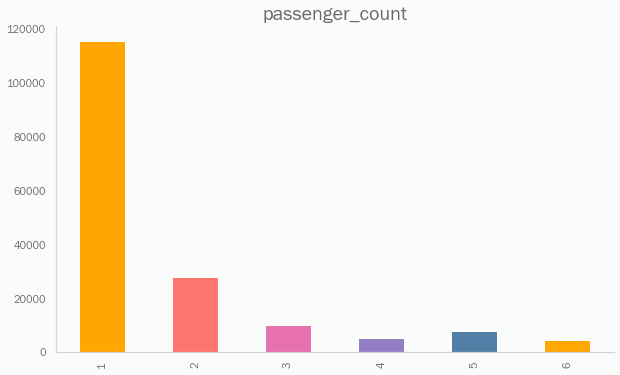

In [35]:
df["passenger_count"].value_counts().sort_index().plot.bar(x='passenger_count', y='Number of Occurrences', color=color_palette, title='passenger_count', figsize=(10, 6))
plt.show()

### Distance, trip duration and speed

**Distance**

In the Figures below we can see both the distribution of the trip distance and the same distribution in a logarithm scale.

It is easy to see that we have an exponential distribution. Most trips are between 0 and 20 milles and the mean is 3 milles. From 20 milles onwards the number of taxi trips starts decreasing. This make sense since we are analysing trips within NY city where distances altough long for a city are not as long compared to road trips.

There are few trips over 40 milles.

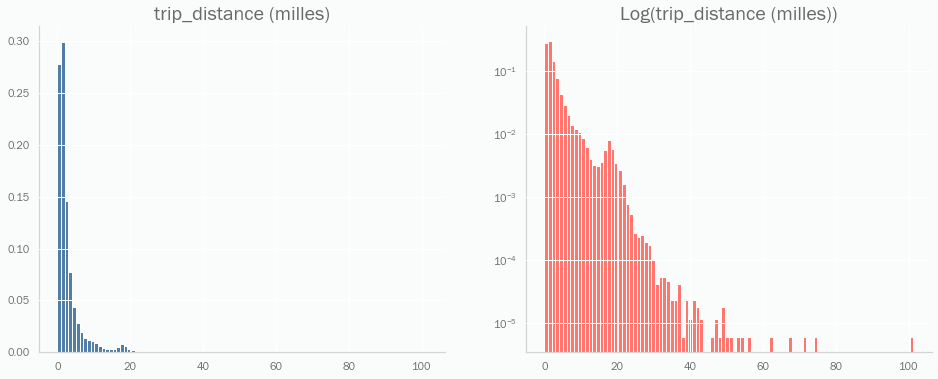

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = df["trip_distance"].hist(bins=100, ax =axes[0], density = True, color = color_palette[4])
ax2 = df["trip_distance"].hist(bins=100, ax =axes[1], density = True, color = color_palette[1], log=True)

ax1.set_title("trip_distance (milles)")
ax2.set_title("Log(trip_distance (milles))")

plt.show()

**Trip duration**

Let's now analyse the trip duration in minutes, since we are used to analyse timelapses in minutes.

Similarly to distance for the duration we have an exponential distribution. Most trips are under an hour and the mean is about 13 min. It is very likely that both these variables are very correlated as we will see later.

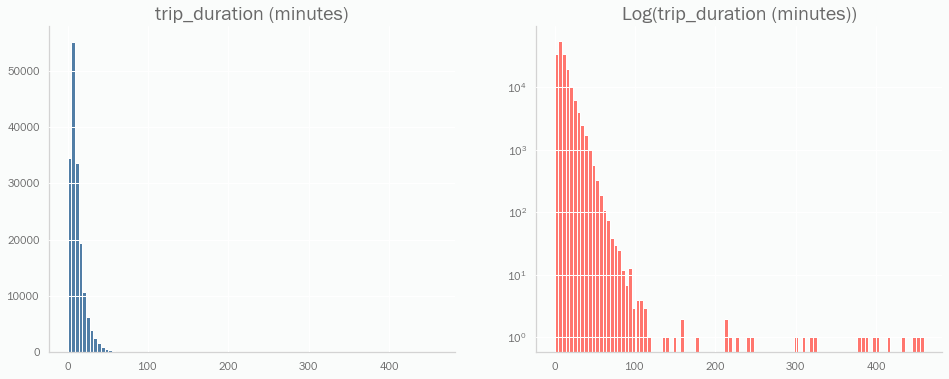

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["trip_duration"] / 60).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["trip_duration"] / 60).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("trip_duration (minutes)")
ax2.set_title("Log(trip_duration (minutes))")

plt.show()

**Trip speed**

The distribution of the trip speed might be more interesting.

In this case we have what it look like a right-skewed normal distribution with a mean of 22 km/h, what it looks like slow speed even for a city, this small mean speed might be due to heavy traffic jams in New York.

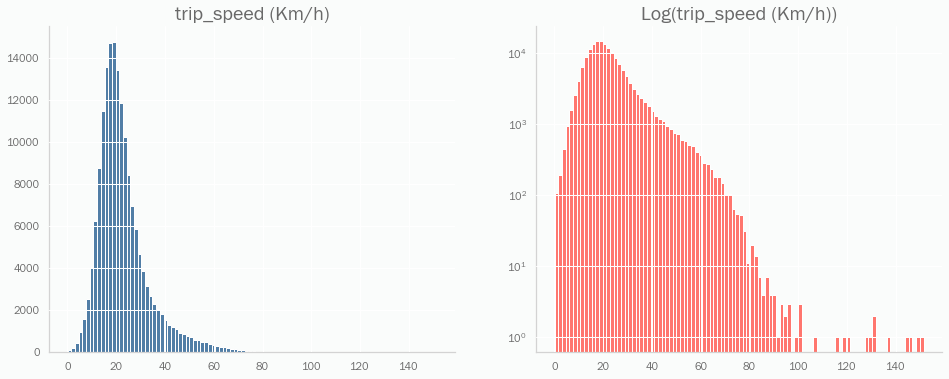

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["trip_speed"]).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["trip_speed"]).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("trip_speed (Km/h)")
ax2.set_title("Log(trip_speed (Km/h))")

plt.show()

### Total amount and trips

It is likely that the total fare is very correlated to the distance and the trip duration, but what about tips? How are they distributed?

**Total amount**

As expected we found an exponential distribution very similar to the distance and duration ones, these variabvles are obviously highly correlated

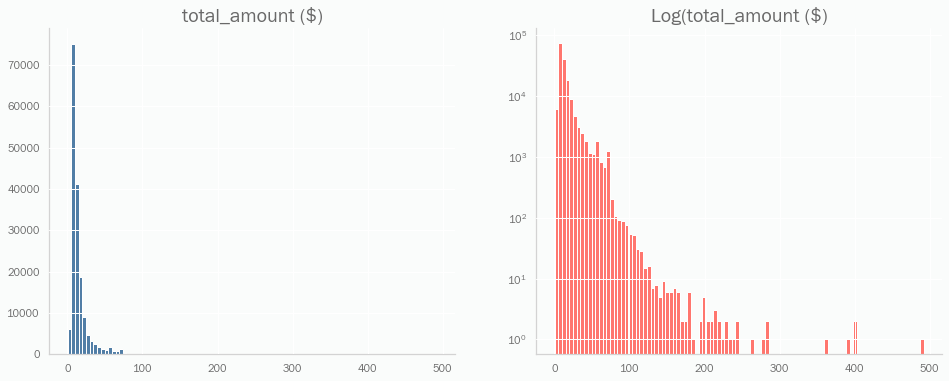

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["total_amount"]).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["total_amount"]).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("total_amount ($)")
ax2.set_title("Log(total_amount ($)")

plt.show()

**Tips**

So tips also seem to follow an exponential distribution and even more exagerated than the total amount of money.

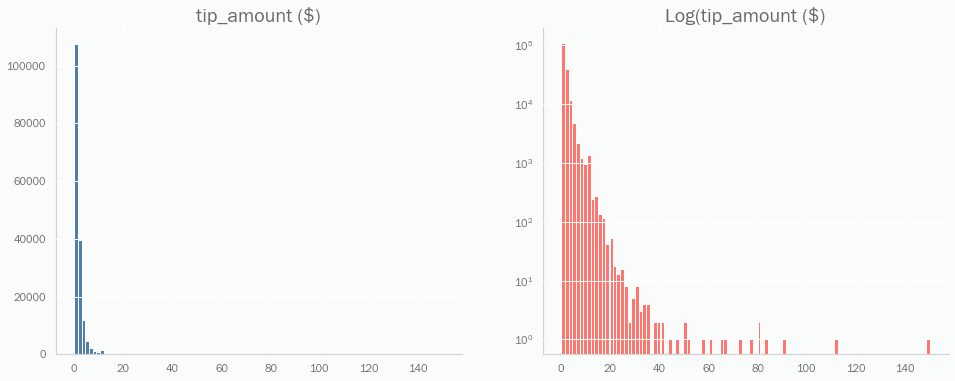

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax1 = (df["tip_amount"]).hist(bins=100, ax =axes[0], color = color_palette[4])
ax2 = (df["tip_amount"]).hist(bins=100, ax =axes[1], color = color_palette[1], log=True)

ax1.set_title("tip_amount ($)")
ax2.set_title("Log(tip_amount ($)")

plt.show()

### Correlation matrix

The next step is to know which variables are highly correlated. This is a very useful method focus the later analysis in some variables and to exclude redundant variables that are correlated from the analysis or from the models to be created.

We will exclude from the correlation matrix some variables we are not interested on: 'extra', 'mta_tax'

We can observe some obvious correlations. For instance, the pickup_hour is highly correlated to the dropoff_hour obviously. All the hypothesis that we had about correlations among trip_duration, trip_distance and total_amount are confirmed as well.

But there are some interesting correlations as well:
* The distance is positively correlated with the trip speed, which implies that higher distances often lead to higher speed.
<br><br>
* The same happends with trip duration and trip speed. In this case the correlation is lower, maybe because sometimes higher durations imply traffic jams and therefore low speed.
<br><br>
* Trip_speed is correlated to total amount but probably because their common connection with trip_distance.
<br><br>
* Another interesting correlation es the tip w.r.t distance and speed, higher distances and speeds often imply higher tips for the driver apparently.
<br><br>
* There is an interesting negative correlation between tip_amount and payment_type. Since payment_type is categorical but was coded as a number it was included in the corr matrix. We can examine this relation later on.

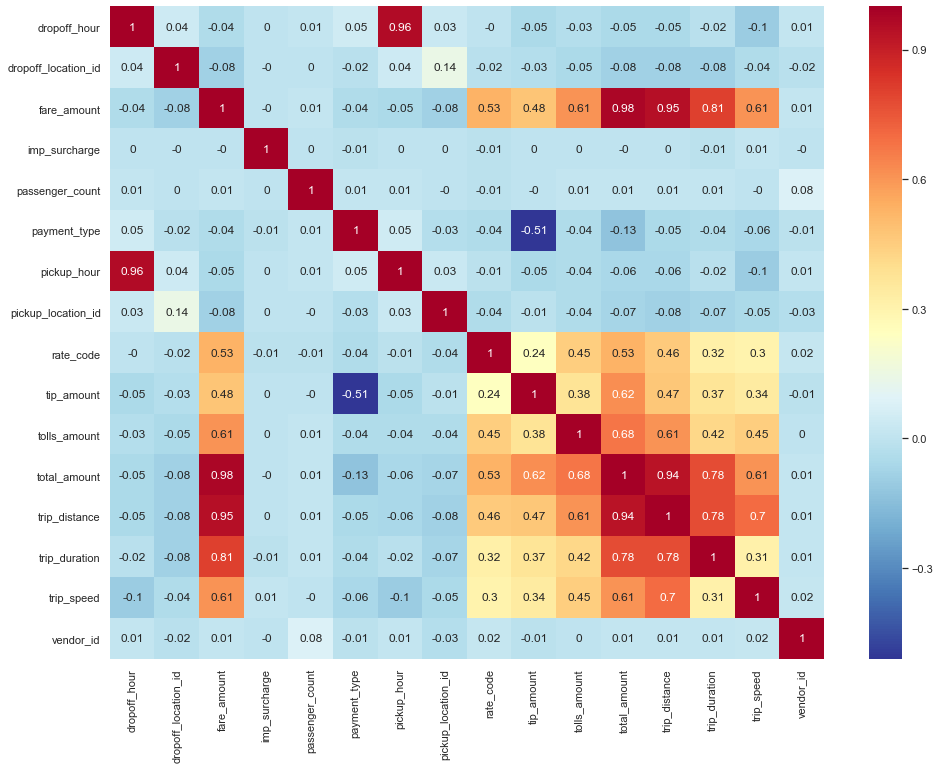

In [41]:
sns.set(rc={'figure.figsize':(16,12)})
sns.heatmap(round(df[df.columns.difference(['extra', 'mta_tax'])].corr(), 2), cmap="RdYlBu_r", annot=True)
plt.show()

### Multivariate analysis: Relations multiple variables

#### Time of day and type of payment

The two main types of payment are Credit card (payment_type = 1) and cash (payment_type = 2).

We can see that is more common to pay with card during Morning, on the other hand it is likely that clients pay with cash during evening. Maybe this is due to the type of clients. During mornings there is probably much more workers taking taxis to office and during evening more yougsters that are morelikely to pay with cash.

It is also remarkable that there is a higher rate of taxi trips lablled as "No Charge" or "Dispute" during night. The NY city council should investigate if taxi drivers have more problems charging clients during late night. 

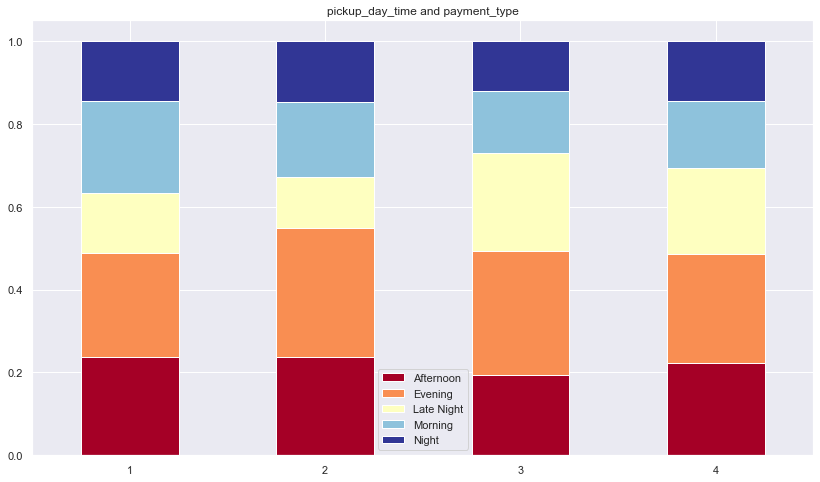

In [42]:
d = dict(df.groupby(['pickup_day_time', 'payment_type']).size())

sub_df1 = pd.DataFrame(d.values(), columns=['count'], index=pd.MultiIndex.from_tuples(d.keys()))
sub_df2 = sub_df1.unstack()
sub_df2.columns = sub_df2.columns.droplevel()  # Drop `count` label.
sub_df2 = sub_df2.div(sub_df2.sum())
sub_df2.T.plot(kind='bar', stacked=True, rot=1, figsize=(14, 8), title="pickup_day_time and payment_type", cmap="RdYlBu")

plt.show()

#### Vendor_id and time of day

The different vendors are more or less equally distributed for the different times of the day:

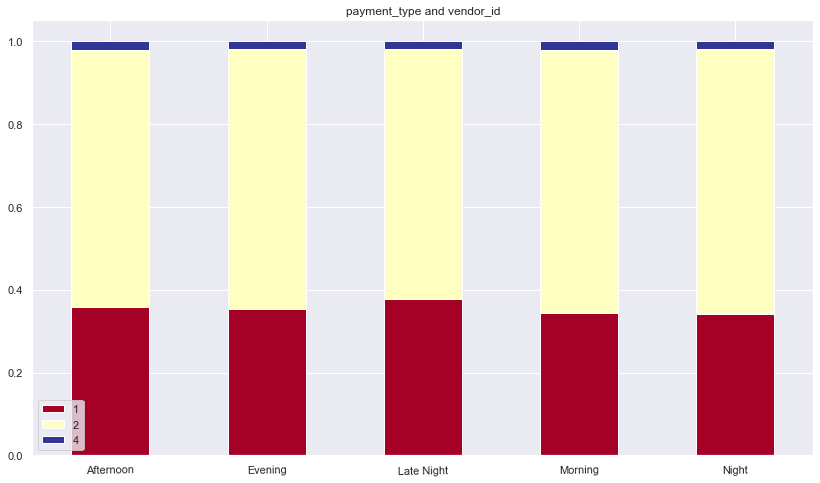

In [43]:
d = dict(df.groupby(['vendor_id', 'pickup_day_time']).size())

sub_df1 = pd.DataFrame(d.values(), columns=['count'], index=pd.MultiIndex.from_tuples(d.keys()))
sub_df2 = sub_df1.unstack()
sub_df2.columns = sub_df2.columns.droplevel()  # Drop `count` label.
sub_df2 = sub_df2.div(sub_df2.sum())
sub_df2.T.plot(kind='bar', stacked=True, rot=1, figsize=(14, 8), title="payment_type and vendor_id", cmap="RdYlBu")

plt.show()

#### Trip speed and time of day

We can see that taxi trips tend to have a higher mean speed during late night. That makes sense since during late night there is not much traffic and cars can drive faster. For the rest of the times the distribution is kind of similar, although trips seem to be a little slower during afternoon.

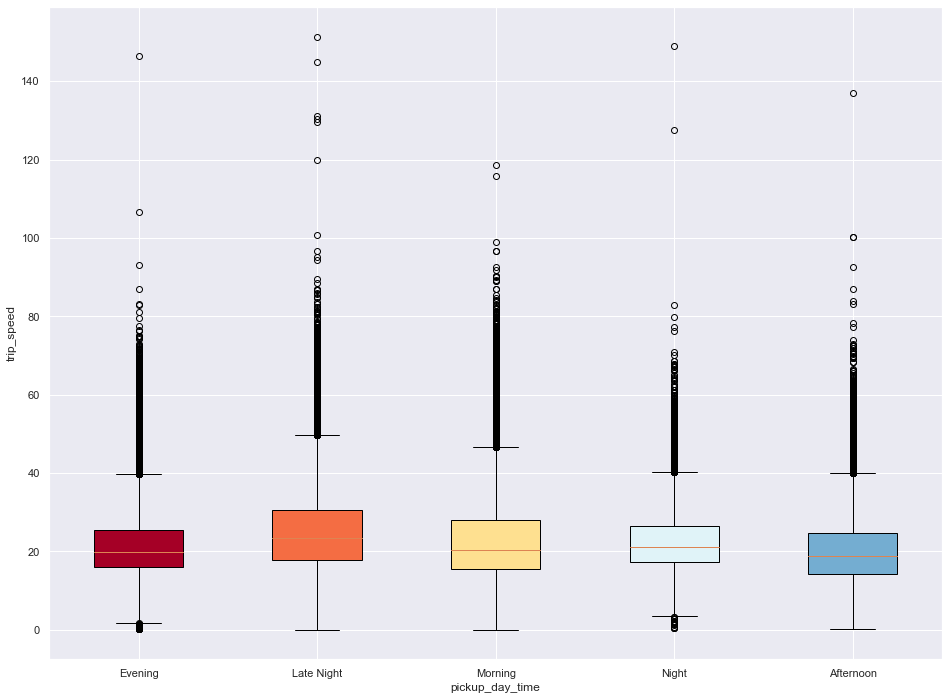

In [44]:
category = "pickup_day_time"
numerical = "trip_speed"

data = [df[df[category] == i][numerical] for i in df[category].unique()]
bplot = plt.boxplot(x=data, patch_artist=True, boxprops=dict(facecolor='black'))

cm = plt.cm.get_cmap('RdYlBu')
colors = [cm(val/len(df[category].unique())) for val in range(len(df[category].unique()))]

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ticks = [i + 1 for i, e in enumerate(df[category].unique())]
labels = [e for i, e in enumerate(df[category].unique())]
plt.xticks(ticks, labels)

plt.xlabel(category)
plt.ylabel(numerical)

plt.show()

#### Payment type and tip amount

It seems like most clients that are giving tips pay with credit card.

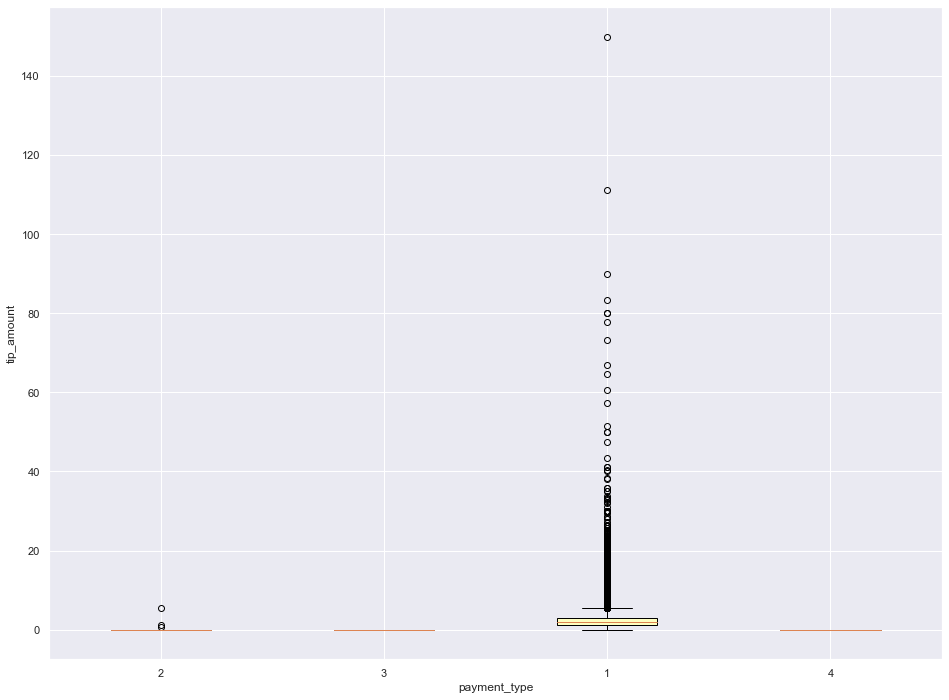

In [45]:
category = "payment_type"
numerical = "tip_amount"

data = [df[df[category] == i][numerical] for i in df[category].unique()]
bplot = plt.boxplot(x=data, patch_artist=True, boxprops=dict(facecolor='black'))

cm = plt.cm.get_cmap('RdYlBu')
colors = [cm(val/len(df[category].unique())) for val in range(len(df[category].unique()))]

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ticks = [i + 1 for i, e in enumerate(df[category].unique())]
labels = [e for i, e in enumerate(df[category].unique())]
plt.xticks(ticks, labels)

plt.xlabel(category)
plt.ylabel(numerical)

plt.show()

#### Distance and speed

We can observe that higher distances often impliy higher speeds. There is actually a threshold around 3 or 4 milles of trip distance where the trend of trip speed starts increasing. Probably from anywhere in NY when you have to make a trip over 3-4 milles it implies to catch a road that allows to drive faster.

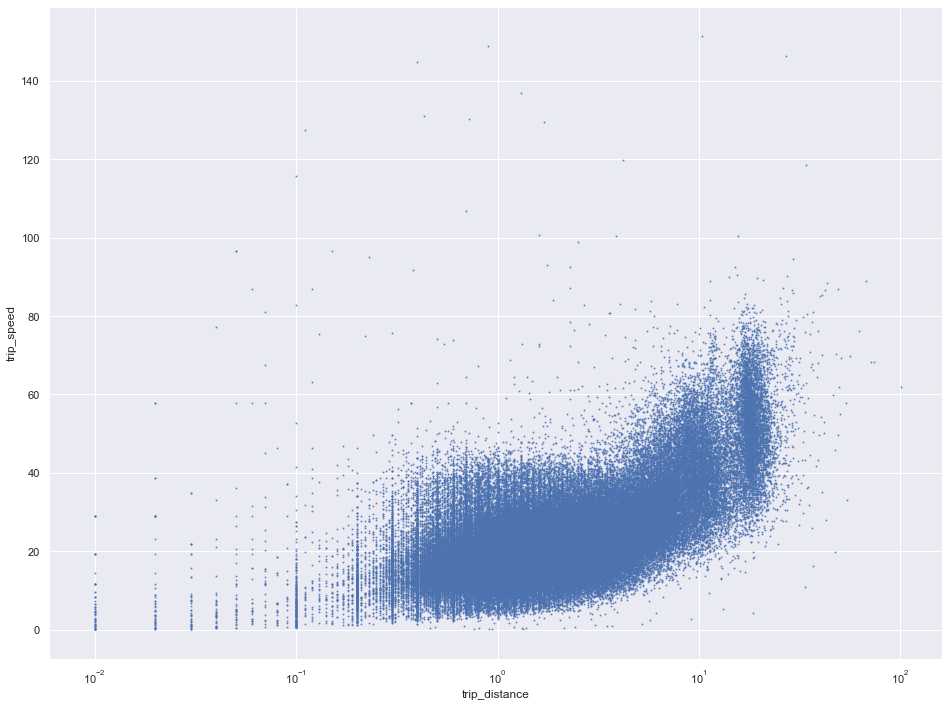

In [46]:
x = "trip_distance"
y = "trip_speed"

fig = plt.figure()
ax = plt.gca()

ax.scatter(x=df[x], y=df[y], s=1, alpha = 0.7)

ax.set_xscale('log')

plt.xlabel(x)
plt.ylabel(y)

plt.show()

#### Tips and speed

For these two variables there is a slight linear dependency indicating that some trips with higher speed often lead to bigger amounts tips.

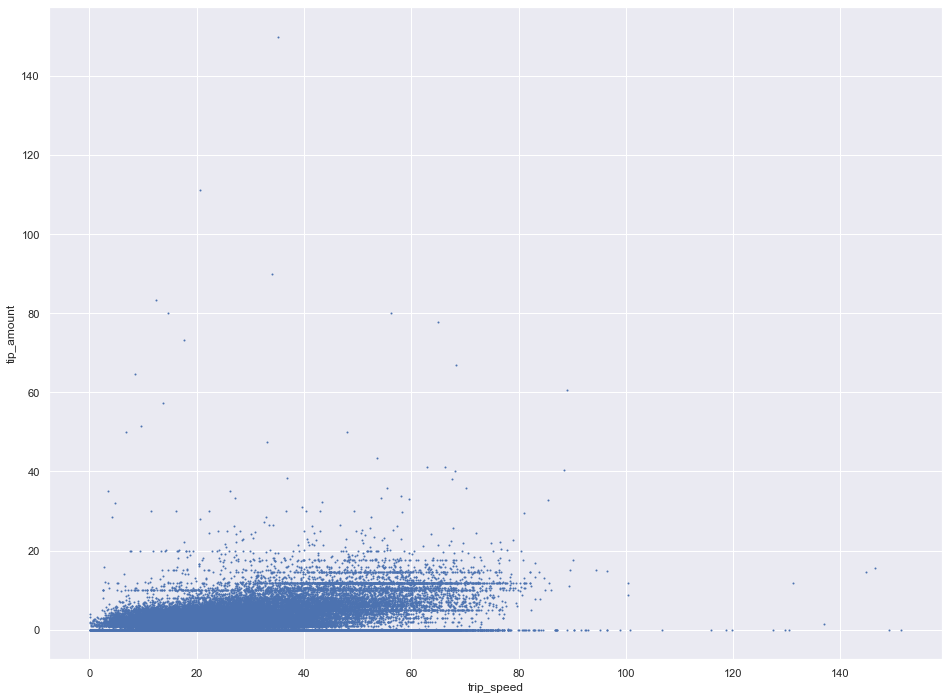

In [47]:
x = "trip_speed"
y = "tip_amount"

fig = plt.figure()
ax = plt.gca()

ax.scatter(x=df[x], y=df[y], s=1)

plt.xlabel(x)
plt.ylabel(y)

plt.show()

#### Distance, speed, and tips

In this chart we displayed the tip amount as the size of the circles and it possible to observe that often larger tips are given in long trips and with high speed.

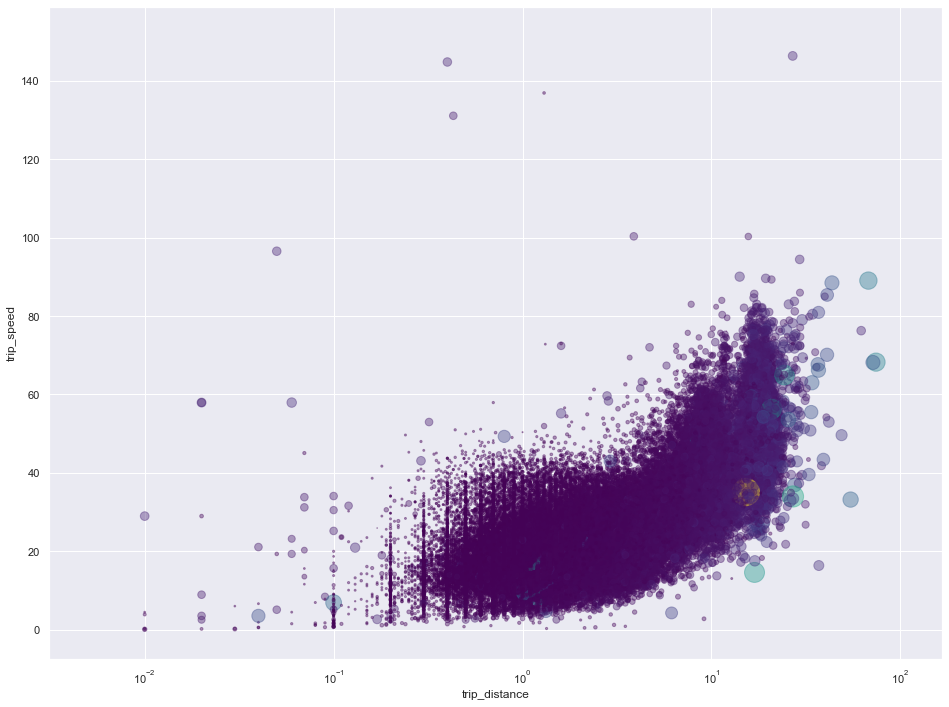

In [48]:
x = "trip_distance"
y = "trip_speed"
s = "tip_amount"

scaler = StandardScaler()

fig = plt.figure()
ax = plt.gca()

c = scaler.fit_transform(np.array(df[s]).reshape(len(df[s]), 1)).ravel()

ax.scatter(x=df[x], y=df[y], s=df[s]*5, c=c*10, alpha = 0.4, cmap="viridis")

ax.set_xscale('log')

plt.xlabel(x)
plt.ylabel(y)

plt.show()

#### Visualazing data on maps

First we import shapes file.

In [49]:
ny_geo = geopandas.read_file("taxi_zones.shp")

By examaning the geo dataframe we see that there are 263 Location IDs with their respective Boroughs, Zones and geo information.

In [50]:
ny_geo.tail()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22..."


Now we can see the NY areas plotted into a map.

In [51]:
ny_geo.crs = {'init' :'epsg:3857'}

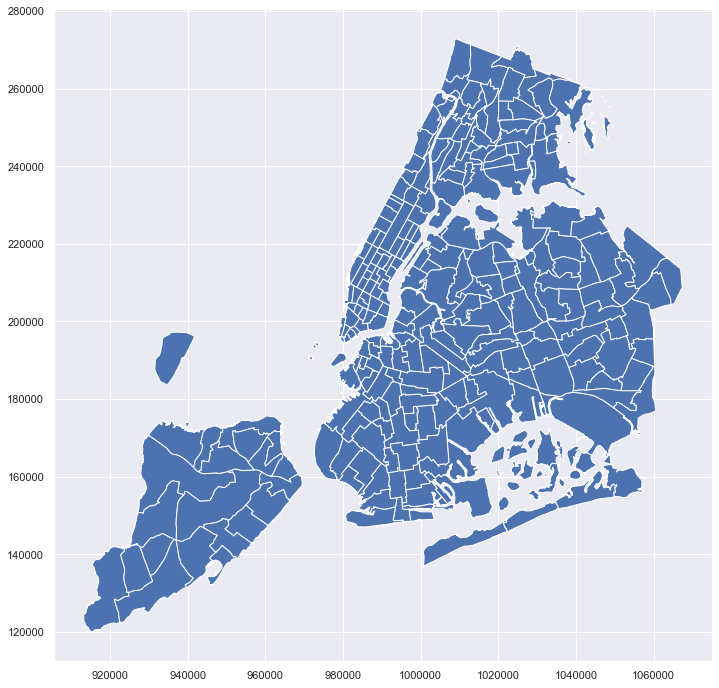

In [52]:
ny_geo.plot()
plt.show()

Let's JOIN the Geo Dataframe with the attributes dataframe so we can plot some info.

In [53]:
df_agg_up = df.groupby(
    "pickup_location_id"
).agg(
    count=("trip_distance", "count"),
    mean_distance=("trip_distance", "mean"),
    median_distance=("trip_distance", "median"),
    max_distance=("trip_distance", "max"),
    mean_duration=("trip_duration", "mean"),
    median_duration=("trip_duration", "median"),
    max_duration=("trip_duration", "max"),
    mean_speed=("trip_speed", "mean"),
    median_speed=("trip_speed", "median"),
    max_speed=("trip_speed", "max"),
    mean_tip=("tip_amount", "mean"),
    median_tip=("tip_amount", "median"),
    max_tip=("tip_amount", "max"),
)

df_agg_off = df.groupby(
    "dropoff_location_id"
).agg(
    count=("trip_distance", "count"),
    mean_distance=("trip_distance", "mean"),
    median_distance=("trip_distance", "median"),
    max_distance=("trip_distance", "max"),
    mean_duration=("trip_duration", "mean"),
    median_duration=("trip_duration", "median"),
    max_duration=("trip_duration", "max"),
    mean_speed=("trip_speed", "mean"),
    median_speed=("trip_speed", "median"),
    max_speed=("trip_speed", "max"),
    mean_tip=("tip_amount", "mean"),
    median_tip=("tip_amount", "median"),
    max_tip=("tip_amount", "max"),
)

In [54]:
df_agg_up.reset_index(inplace=True)
df_agg_off.reset_index(inplace=True)

In [55]:
df_agg_up.head(3)

,pickup_location_id,count,mean_distance,median_distance,max_distance,mean_duration,median_duration,max_duration,mean_speed,median_speed,max_speed,mean_tip,median_tip,max_tip
0,1,1,0.060000,0.06,0.06,6.000000,6.0,6.0,57.936240,57.936240,57.936240,18.160000,18.16,18.16
1,3,7,6.062857,2.95,20.41,1358.571429,1029.0,3486.0,22.168284,22.336864,37.742211,0.638571,0.00,4.47
2,4,418,3.479402,2.35,19.03,761.741627,642.0,3286.0,23.952267,20.855373,81.110736,1.295120,0.00,10.56


In [56]:
ny_geo_up_enriched = pd.merge(ny_geo, df_agg_up, how='left', left_on=['LocationID'], right_on=['pickup_location_id'])
ny_geo_off_enriched = pd.merge(ny_geo, df_agg_off, how='left', left_on=['LocationID'], right_on=['dropoff_location_id'])

Where people take more taxi rides from (pick-up location):

By seeing the map the red colors are located within Manhattan. This is the area where most taxi rides are taken. There is also an area, in the south of Queens where taxis are also taken with more frequency.

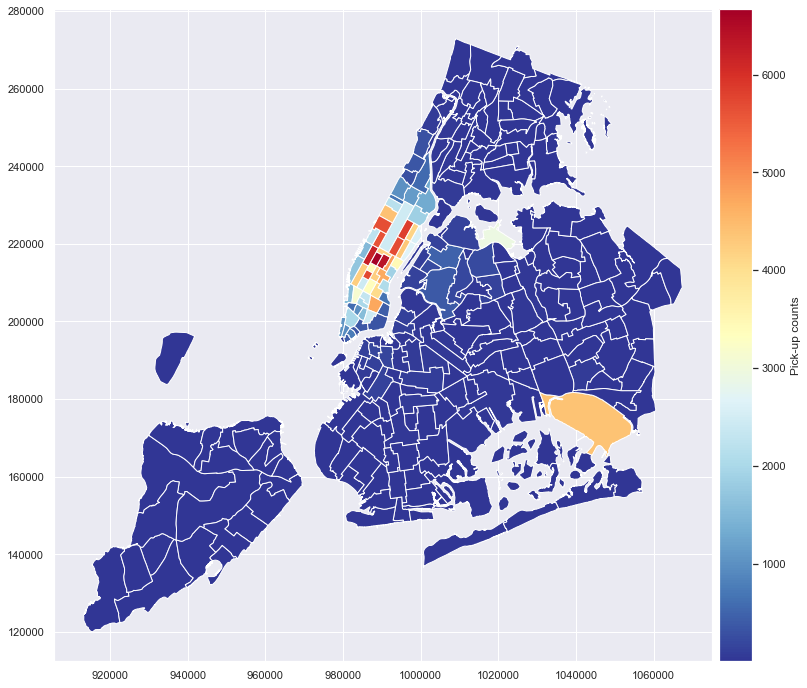

In [57]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_up_enriched.plot(column="count", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Pick-up counts"})
plt.show()

Let's now see where more passengers are being drop-off:

The information looks very similar to where taxis are picked up. Probably most of the rides are within Manhattan.

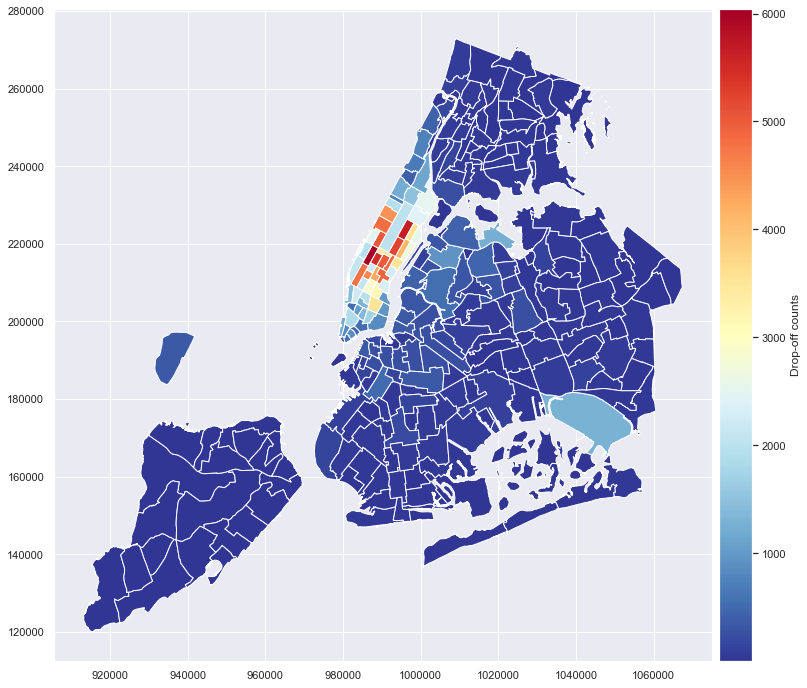

In [58]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_off_enriched.plot(column="count", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Drop-off counts"})
plt.show()

Let's see where the taxi rides with more distance are ending.
As it was expected taxi rides with higher average distance finish in districts that are distant from Manhattan, probably there is a flow of people going from Manhattan to residential areas, airport, etc, i.e., where the day life takes place to their homes. Colors in Manhattan show that distances of taxi trips finishing in this area are very low, as they are most likely moving within Manhattan.

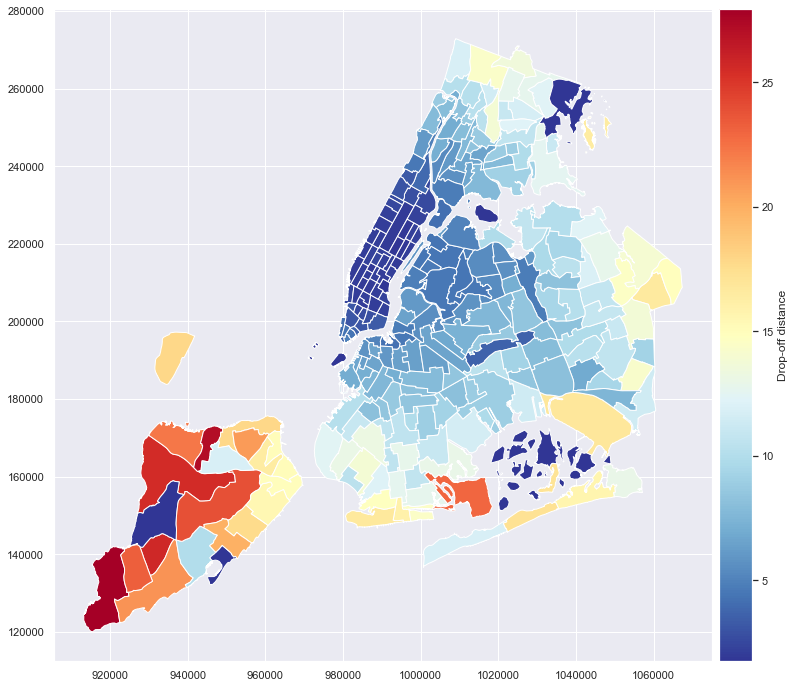

In [59]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_off_enriched.plot(column="mean_distance", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Drop-off distance"})
plt.show()

If we plot the trip duration we expect to see a similar pattern in the map.

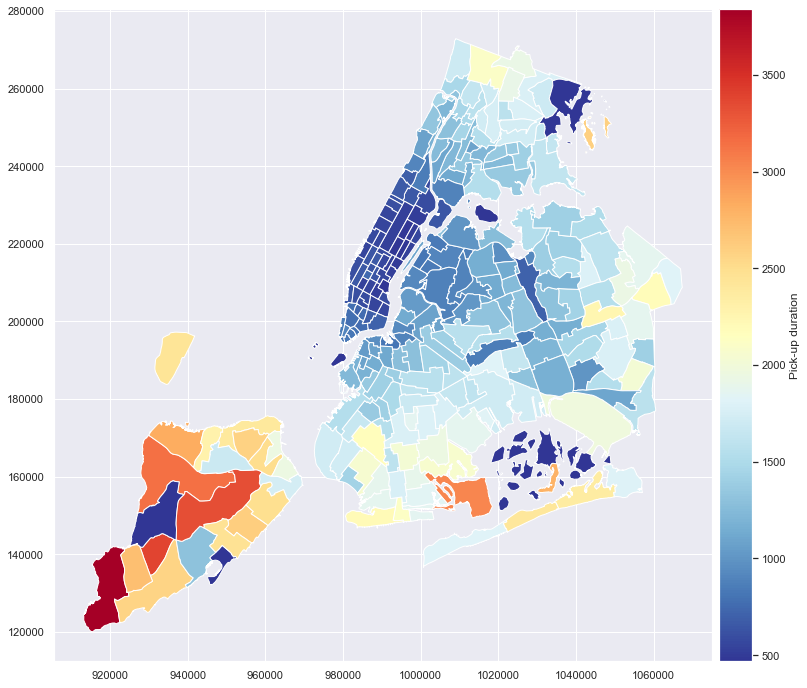

In [60]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_off_enriched.plot(column="mean_duration", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Pick-up duration"})
plt.show()

What about the speed?

Areas in the outskirts of the city tend to have higher average trip speed.

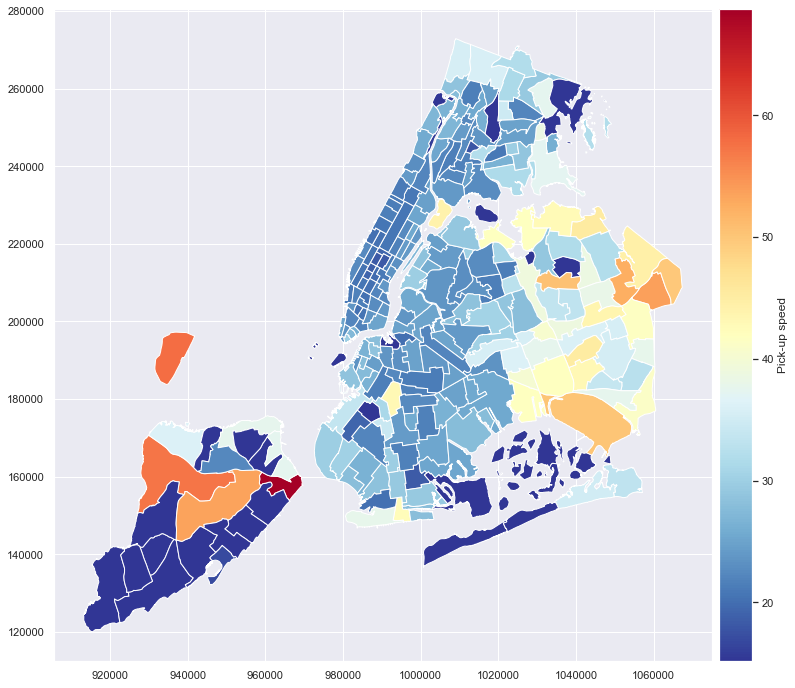

In [61]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_up_enriched.plot(column="mean_speed", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Pick-up speed"})
plt.show()

It happends the same for drop-off but even more exaggerated

Let's finally visualize the tips.

It looks like certain people going down in some areas tend to give a higher tip. For instance, people in an area in the South of Queens and people being drop-off in some areas of Staten Island. Also people being drop-off at the Newark airport are giving much higher tips on average.

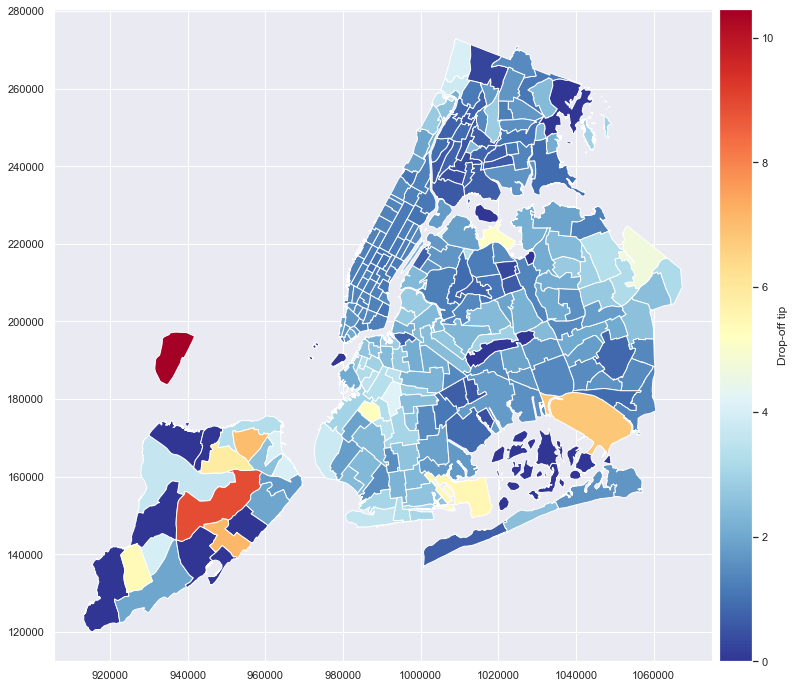

In [62]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_off_enriched.plot(column="mean_tip", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Drop-off tip"})
plt.show()

On the other hand it looks like just people picking-up taxis at the airport are giving higher tips.

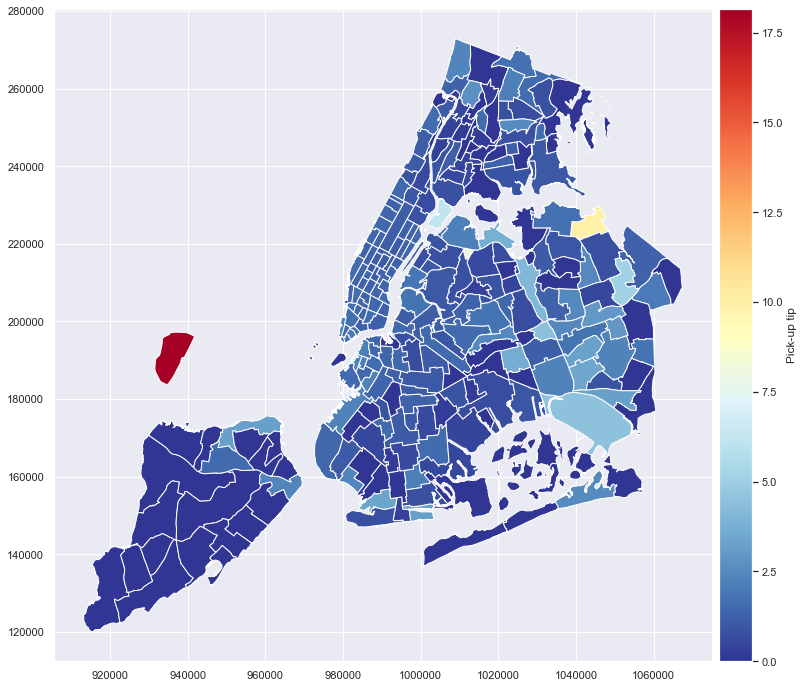

In [63]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ny_geo_up_enriched.plot(column="mean_tip", ax=ax, legend=True, cmap="RdYlBu_r", cax=cax, legend_kwds={'label': "Pick-up tip"})
plt.show()

## 3. Model Building

In this section the purpose is try to understand how tips behave by using a machine learning mode. The process will involve training a model to predict trips based on the available samples and variables. Finally, we will attempt to extract some insights and understand which are the variables that influence the tips the most.

### Selecting features and Target

In [64]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,...,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,trip_duration,trip_speed,pickup_hour,dropoff_hour,pickup_day_time,dropoff_day_time
0,1,2018-11-22 20:32:28,2018-11-22 20:33:35,1,0.6,5,N,2,0.01,0.0,...,0.3,0.31,132,132,67.0,51.883200,20,20,Evening,Evening
1,1,2018-11-22 17:54:06,2018-11-22 18:02:38,2,1.6,5,N,2,0.01,0.0,...,0.3,0.31,79,164,512.0,18.105075,17,18,Evening,Evening
2,1,2018-11-22 01:13:40,2018-11-22 01:22:00,2,0.1,5,N,3,0.01,0.0,...,0.3,0.31,48,48,500.0,1.158725,1,1,Late Night,Late Night
3,1,2018-11-22 07:01:31,2018-11-22 07:05:03,1,2.5,5,Y,3,0.01,0.0,...,0.3,0.31,132,130,212.0,68.321038,7,7,Morning,Morning
4,1,2018-11-22 20:35:44,2018-11-22 20:47:33,1,1.4,5,N,2,0.01,0.0,...,0.3,0.31,159,42,709.0,11.440160,20,20,Evening,Evening


Now it is time to select the features that we are going to use to train the model to predict tips. Based on the knowledge we acquired with previous analysis we can make a good selection of model features. 

We avoid including redundant features such as fare_amount, total_amount... and we will include only one of them. We will include all variables related to trip information, such as distance, duration, speed. Besides, we will include vendor_id.

* **Target:** tip_amount
* **Features:** payment_type, rate_code, total_amount, trip_distance, trip_duration, trip_speed, vendor_id and pickup_day_time

In [65]:
len(np.array(df["tip_amount"]))

170194

In [66]:
df["dropoff_location_id"].nunique()

257

In [67]:
target = "tip_amount"
numerical_features = ["total_amount", "trip_distance", "trip_duration", "trip_speed"]
categorical_features = ["payment_type", "rate_code", "vendor_id", "pickup_day_time"]

### One-hot encoding caterogical features

Machine learning models cannot cope with categories. At the end of the day a ML learning model is based on statistical models that operate with numbers, hence, we need to convert categories into numerical vectors. To do so, we transform categories to one-hot encoded vectors. 

For instance, a category with 3 values: A, B and C can be one-hot encoded as A = 100, B = 010, C = 001.

In [68]:
encoder = OneHotEncoder()
categorical_feat_encoded = encoder.fit_transform(np.array(df[categorical_features])).toarray()

Before one-hot encoding

In [69]:
df[["payment_type", "rate_code", "vendor_id", "pickup_day_time"]][:1]

,payment_type,rate_code,vendor_id,pickup_day_time
0,2,5,1,Evening


After one-hot encoding.

In [70]:
categorical_feat_encoded[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])

 Thereshould be 17 resulting columns in the resulting array

In [71]:
df["payment_type"].nunique() + df["rate_code"].nunique() + df["vendor_id"].nunique() + df["pickup_day_time"].nunique()

17

In [72]:
categorical_feat_encoded.shape

(170194, 17)

### Scaling data: Normalization and Standardization (Z-scores)

Often Machine Learning models and even more regression models rely on calculating distances. Therefore, when we have data with very different distributions and magnitudes it can affect badly the performance of model.

We can solve that with two approaches, normalization and standardization. Normalization scales everything in the [0, 1] interval, meanwhile Standardization scales everythin to fit a distribution of mean 0 and std=1 and copes better with outliers. For this later reason we have choosen Standardization to scale our data.

In [73]:
scaler = StandardScaler()

numerical_feat_standard = scaler.fit_transform(np.array(df[numerical_features]))

In [74]:
np.array(df[numerical_features]).shape

(170194, 4)

In [75]:
np.array(df[numerical_features])

array([[3.10000000e-01, 6.00000000e-01, 6.70000000e+01, 5.18832000e+01],
       [3.10000000e-01, 1.60000000e+00, 5.12000000e+02, 1.81050750e+01],
       [3.10000000e-01, 1.00000000e-01, 5.00000000e+02, 1.15872480e+00],
       ...,
       [2.50900000e+01, 8.38000000e+00, 2.00900000e+03, 2.41665352e+01],
       [3.92700000e+01, 1.14200000e+01, 2.64900000e+03, 2.49766652e+01],
       [2.47500000e+01, 8.45000000e+00, 1.02900000e+03, 4.75764070e+01]])

In [76]:
numerical_feat_standard.shape

(170194, 4)

In [77]:
numerical_feat_standard

array([[-1.06547159, -0.62365571, -1.04626462,  2.70253795],
       [-1.06547159, -0.36792332, -0.29524951, -0.43088684],
       [-1.06547159, -0.7515219 , -0.31550161, -2.00291353],
       ...,
       [ 0.75477134,  1.36594223,  2.23119908,  0.13140397],
       [ 1.79637927,  2.14336868,  3.3113107 ,  0.20655562],
       [ 0.72979625,  1.3838435 ,  0.57727816,  2.30301868]])

We check that indeed the distribution of the variables has changed to mean 0 and standard deviation 1.

In [78]:
print(numerical_feat_standard[:, 1].mean())
print(numerical_feat_standard[:, 1].std())

-2.498259474945321e-16
0.9999999999999999


#### Now we just concatenate bot numerical and categorical feature arrays.

In [79]:
np.concatenate((numerical_feat_standard,categorical_feat_encoded),axis=1).shape

(170194, 21)

In [80]:
np.array(df["tip_amount"]).reshape(len(df["tip_amount"]), 1).shape

(170194, 1)

In [81]:
X = np.concatenate((numerical_feat_standard,categorical_feat_encoded),axis=1)
Y = np.array(df["tip_amount"]).reshape(len(df["tip_amount"]), 1)

In [82]:
X.shape

(170194, 21)

In [83]:
Y.shape

(170194, 1)

### Train and test sets

Now we will divide the dataset into training and test sets. The training set will be used to train the model to learn structures in data to predict tips amount. The test set will be used to evaluate the performance of the model built on unseen data. In that way we will be able to check that the model is able to generalise.

* Train: We will use 80% of samples to train.
* Test: We will use 20% of samples to test.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
y_train = y_train.ravel()
y_test = y_test.ravel()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(136155, 21)
(34039, 21)
(136155,)
(34039,)


### Model selection

We will select a set of different regression models to compare performance among them.

In [85]:
models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNeighborsRegressor": KNeighborsRegressor()
}

We validate the performance of our models using k-fold cross validation with a k = 5. We will use as performance errors:
* neg_mean_squared_error
* neg_median_absolute_error
* neg_mean_absolute_error
* r2

In [86]:
performance = dict()

for name, model in tqdm(models.items()):
    performance[name] = cross_validate(model, X_train, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error', 'neg_median_absolute_error', 'neg_mean_absolute_error'))

Finally we print the performance metrics in terms of error for each model. The resulting errors are obtained by calculating the mean for the errors obtained for each fold of the cross validation.

We can observe the different metrics for the models we trained. Even if we see test followed by the error in te results, this would be the validation score. We will analyse test errors afterwards with the test dataset.

In [87]:
for model, errors in performance.items():
    print(model + "\n")
    for error, values in errors.items():
        if error in ['test_neg_mean_squared_error', 'test_neg_median_absolute_error', 'test_neg_mean_absolute_error']:
            print("\t" + error + ":\t" + str(round(np.mean(values),2)) + " (mean)\t" + str(round(np.std(values),2)) + "(std)")
        elif error in ["test_r2"]:
            print("\t" + error + ":\t\t\t " + str(round(np.mean(values),2)) + " (mean)\t" + str(round(np.std(values),2)) + "(std)")
    print("\n")

RandomForest

	test_r2:			 0.87 (mean)	0.03(std)
	test_neg_mean_squared_error:	-0.69 (mean)	0.21(std)
	test_neg_median_absolute_error:	-0.0 (mean)	0.0(std)
	test_neg_mean_absolute_error:	-0.15 (mean)	0.01(std)


LinearRegression

	test_r2:			 0.66 (mean)	0.01(std)
	test_neg_mean_squared_error:	-1.8 (mean)	0.14(std)
	test_neg_median_absolute_error:	-0.39 (mean)	0.0(std)
	test_neg_mean_absolute_error:	-0.67 (mean)	0.01(std)


Lasso

	test_r2:			 0.19 (mean)	0.01(std)
	test_neg_mean_squared_error:	-4.33 (mean)	0.36(std)
	test_neg_median_absolute_error:	-1.19 (mean)	0.01(std)
	test_neg_mean_absolute_error:	-1.34 (mean)	0.01(std)


Ridge

	test_r2:			 0.66 (mean)	0.01(std)
	test_neg_mean_squared_error:	-1.8 (mean)	0.14(std)
	test_neg_median_absolute_error:	-0.39 (mean)	0.0(std)
	test_neg_mean_absolute_error:	-0.67 (mean)	0.01(std)


KNeighborsRegressor

	test_r2:			 0.79 (mean)	0.03(std)
	test_neg_mean_squared_error:	-1.14 (mean)	0.25(std)
	test_neg_median_absolute_error:	-0.05 (mean)	0.0(s

Let's now execute our models on the test set.

In [88]:
performance_test = dict()

for name, model in tqdm(models.items()):
    md = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performance_test[name] = {
        'r2_score': round(r2_score(y_test, y_pred), 2),
        'mean_squared_error' :round(mean_squared_error(y_test, y_pred), 2),
        'median_absolute_error': round(median_absolute_error(y_test, y_pred), 2),
        'mean_absolute_error': round(mean_absolute_error(y_test, y_pred), 2)}

We can see that RandomForest and KNeighboursRegressor provide the best results for MSE and MAE but the performance is worse R2. On the other hand, Lasso seems to be the model performing the best for the R2 score. We do not observe any strong overfiting.

In [89]:
for model, performance in performance_test.items():
    print(model)
    for error, value in performance.items():
        if error in ['mean_squared_error', 'median_absolute_error', 'mean_absolute_error']:
            print("\t" + error + ": \t" + str(value) + " (mean)\t")
        elif error in ["r2_score"]:
            print("\t" + error + ":\t\t " + str(value) + " (mean)\t")
    print("\n")

RandomForest
	r2_score:		 0.83 (mean)	
	mean_squared_error: 	1.04 (mean)	
	median_absolute_error: 	0.0 (mean)	
	mean_absolute_error: 	0.15 (mean)	


LinearRegression
	r2_score:		 0.63 (mean)	
	mean_squared_error: 	2.33 (mean)	
	median_absolute_error: 	0.39 (mean)	
	mean_absolute_error: 	0.68 (mean)	


Lasso
	r2_score:		 0.18 (mean)	
	mean_squared_error: 	5.12 (mean)	
	median_absolute_error: 	1.19 (mean)	
	mean_absolute_error: 	1.35 (mean)	


Ridge
	r2_score:		 0.63 (mean)	
	mean_squared_error: 	2.33 (mean)	
	median_absolute_error: 	0.39 (mean)	
	mean_absolute_error: 	0.68 (mean)	


KNeighborsRegressor
	r2_score:		 0.75 (mean)	
	mean_squared_error: 	1.54 (mean)	
	median_absolute_error: 	0.04 (mean)	
	mean_absolute_error: 	0.31 (mean)	




By looking at the average value of tips (1.448), we can see that some models are able to perform more or less, taking into account that we have not tuned any hyper parameter or tried any more powerful model such as Neural Netowrks or Catboost Regressor. The performance could be improved, but for the scope of the projects the results are satisfactory.

The hypothesis is that given the exponential distribution of tips, it is most likely that models learnt to predict values around the mean and median of the distribution, but maybe are less effective when predicting values on the right tail of the distribution (higher tips).

In [90]:
df["tip_amount"].mean()

1.4486523026661107